# A full look into `providers` objects

In [1]:
import xyzservices.providers as xyz

## What is this "provider" object ?

The provider objects are stored as dictionaries (with attribute access for easy access), so we can explore them in Python (or using tab completion in an interactive session or as a collapsible inventory in Jupyter!):

In [2]:
xyz

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'}},
 'OpenSeaMap': {'url': 'https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
  'html_attribution': 'Map data: &copy; <a href="http://www.openseamap.org">OpenSeaMap</a> contributors',
  'attribution': 'Map data: (C) OpenSeaMap contributors',
  'name': 'OpenSeaMap'},
 'OpenPtMap': {'url': 'http://openptmap.org/tiles/{z}/{x}/{y}.png',
  'max_zoom': 17,
  'html_attribution': 'Map data: &copy; <a href="http://www.openptmap.org">OpenPtMap</a> contributors',
  'attribution': 'Map data: (C) OpenPtMap contributors',
  'name': 'OpenPtMap'},
 'OpenTopoMap': {'url': 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
  'max_zoom': 17,
  'html_attribution': 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
  'attribution': 'Map data: (C) OpenStreetMap contributors, SRTM | Map style: (C) OpenTopoMap (CC-BY-SA)',
  'name': 'OpenTopoMap'},
 'OpenRailwayMap': {'url': 'https://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
  'max_zoom': 19,
  'html_attribution': 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors | Map style: &copy; <a href="https://www.OpenRailwayMap.org">OpenRailwayMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
  'attribution': 'Map data: (C) OpenStreetMap contributors | Map style: (C) OpenRailwayMap (CC-BY-SA)',
  'name': 'OpenRailwayMap'},
 'OpenFireMap': {'url': 'http://openfiremap.org/hytiles/{z}/{x}/{y}.png',


Most of those providers have themselves multiple options. For example, OpenStreetMap provides multiple background styles:

In [3]:
xyz.OpenStreetMap

{'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
  'max_zoom': 19,
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': '(C) OpenStreetMap contributors',
  'name': 'OpenStreetMap.Mapnik'},
 'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
  'max_zoom': 18,
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': '(C) OpenStreetMap contributors',
  'name': 'OpenStreetMap.DE'},
 'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
  'max_zoom': 18,
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': '(C) OpenStreetMap contributors',
  'bounds': [[45, 5], [48, 11]],
  'name': 'OpenStreetMap.CH'},
 'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
  'max_zoom': 20,
  'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
  'name': 'OpenStreetMap.France'},
 'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
  'max_zoom': 19,
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
  'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
  'name': 'OpenStreetMap.HOT'},
 'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
  'max_zoom': 19,
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
  'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
  'bounds': [[46.2, -5.5], [50, 0.7]],
  'name': 'OpenStreetMap.BZH'}}

Looking at a single one of those options, for example "Mapnik" (the default OpenStreetMap background), we can see this is a `TileProvider` object, which behaves as a dict:

In [4]:
type(xyz.OpenStreetMap.Mapnik)

xyzservices.lib.TileProvider

We can explore its contents:

In [5]:
xyz.OpenStreetMap.Mapnik

{'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
 'max_zoom': 19,
 'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
 'attribution': '(C) OpenStreetMap contributors',
 'name': 'OpenStreetMap.Mapnik'}

A "provider object" is then a dictionary with a few required entries, such as the url (required, with `{z}/{x}/{y}` to be replaced), with some additional metadata information (optional). These can be the attribution text to be used on the plot (`attribution`), or the maximum zoom level available for these tiles (`max_zoom`). When this information is available, other libraries like `geopandas` or `contextily` may be smart enough to access and use it automatically.

## Which providers are available by default?

The providers definitions that are shipped with `xyzservices` in the `xyzservices.providers` submodule, are coming from the [`leaflet-providers`](https://github.com/leaflet-extras/leaflet-providers) package, an extension to javascript mapping library Leaflet that contains configurations for various free tile providers. Thus, all providers that are listed on their preview (http://leaflet-extras.github.io/leaflet-providers/preview/) should also be available in `xyzservices`. On top of that, `xyzservices` can have a few more as a bonus.

## Specifying options for a provider

Some providers require additional information, such as an API access key. This can be specified by calling the provider object. Any keyword specified will override the default value in the provider object.

For example, the OpenWeatherMap requires an API key:

In [6]:
xyz.OpenWeatherMap.Clouds

{'url': 'http://{s}.tile.openweathermap.org/map/{variant}/{z}/{x}/{y}.png?appid={apiKey}',
 'max_zoom': 19,
 'html_attribution': 'Map data &copy; <a href="http://openweathermap.org">OpenWeatherMap</a>',
 'attribution': 'Map data (C) OpenWeatherMap',
 'apiKey': '<insert your api key here>',
 'opacity': 0.5,
 'variant': 'clouds',
 'name': 'OpenWeatherMap.Clouds'}

In [7]:
xyz.OpenWeatherMap.Clouds.requires_token()

True

We can specify this API key by calling the object or overriding the attribute:

In [8]:
# Overriding the attribute will alter existing object
xyz.OpenWeatherMap.Clouds["apiKey"] = "my-private-api-key"

# Calling the object will return a copy
xyz.OpenWeatherMap.Clouds(apiKey="my-private-api-key")

{'url': 'http://{s}.tile.openweathermap.org/map/{variant}/{z}/{x}/{y}.png?appid={apiKey}',
 'max_zoom': 19,
 'html_attribution': 'Map data &copy; <a href="http://openweathermap.org">OpenWeatherMap</a>',
 'attribution': 'Map data (C) OpenWeatherMap',
 'apiKey': 'my-private-api-key',
 'opacity': 0.5,
 'variant': 'clouds',
 'name': 'OpenWeatherMap.Clouds'}

This can then be specified where a key or token is expected. For example:
    
```python
contextily.add_basemap(ax, source=xyz.OpenWeatherMap.Clouds(apiKey="my-private-api-key"))
```


## Building the tile URL

Some packages like `contextily` can use `xyzservices.TileProvider` directly and parse the required information under the hood. Others need and explicit URL string, attribution and other attributes. However, not every package need the URL in the same format. `xyzsevices` can build the URL in most of the required formats, with or without placeholders.

Typical use case would be a folium map, which needs an URL and an attribution with `{x}`, `{y}` and `{z}` placeholders but already filled API keys if needed. You can get the most standard URL in the  `'https://myserver.com/tiles/{z}/{x}/{y}.png'` format via `TileProvider.build_url()`. And if you want a sharper resolution (when supported by the provider), you can pass an optional `scale_factor` attribute.

In [9]:
import folium

tiles = xyz.CartoDB.Positron

folium.Map(
    location=[53.4108, -2.9358],
    tiles=tiles.build_url(scale_factor="@2x"),
    attr=tiles.attribution,
)

If you need an URL of a single tile, you can pass `x`, `y` and `z` directly, alongside other required attributes like `accessToken`.

In [10]:
xyz.OpenWeatherMap.Clouds.build_url(x=12, y=21, z=15, apiKey="my-private-api-key")

'http://a.tile.openweathermap.org/map/clouds/15/12/21.png?appid=my-private-api-key'

## Overview of built-in providers

Let us create a flat dictionary of the built-in providers:

In [11]:
providers = xyz.flatten()

This results in quite a few of them already available:

In [12]:
len(providers)

207

For this illustration, let's single out the following ones and use `contextily` to have a look at them:

In [13]:
selection = ['OpenStreetMap.Mapnik', 
             'OpenTopoMap', 
             'Stamen.Toner', 
             'Stamen.TonerLite', 
             'Stamen.Terrain', 
             'Stamen.TerrainBackground', 
             'Stamen.Watercolor', 
             'NASAGIBS.ViirsEarthAtNight2012', 
             'CartoDB.Positron', 
             'CartoDB.Voyager'
            ]

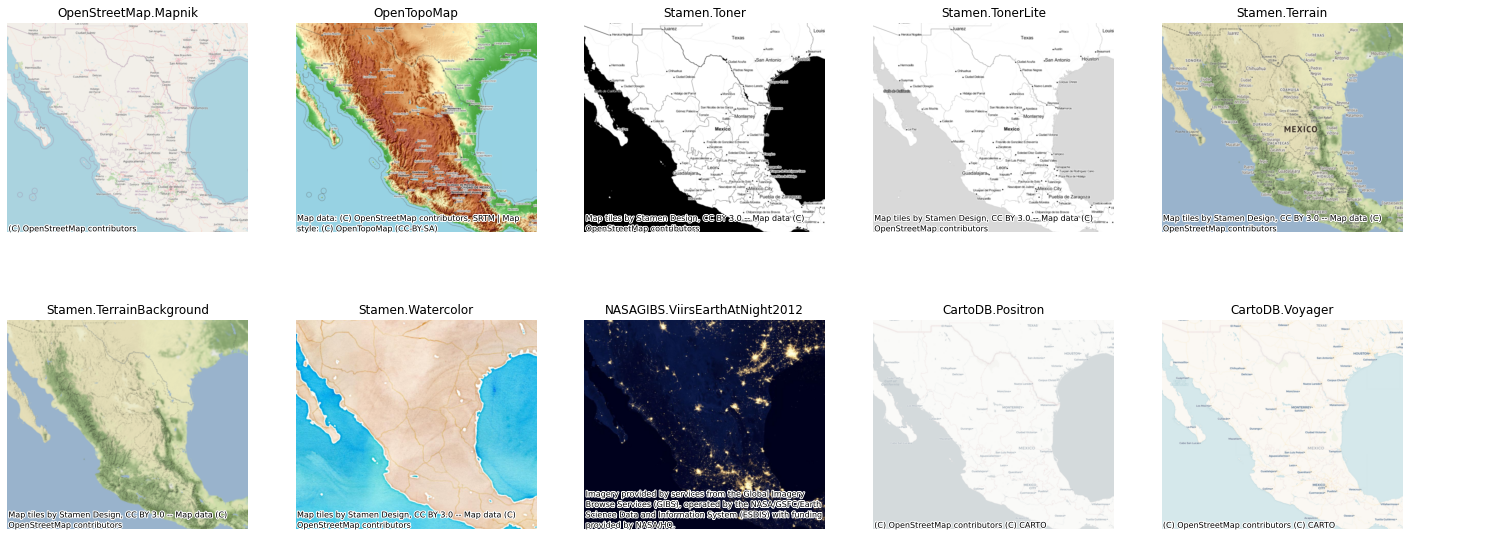

In [14]:
import matplotlib.pyplot as plt
import contextily

# we are using an extent around Mexico for the examples
extent = (-12600000, -10300000, 1800000, 3800000)

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
axs = axs.flatten()
for name, ax in zip(selection, axs):
    ax.axis(extent)
    contextily.add_basemap(ax, source=providers[name])
    ax.set_title(name)
    ax.set_axis_off()
plt.show()